# Toffoli-Based Circuit for Modular Exponentiation in Shor's Algorithm

**Author:** Ayomide Olumide-Attah

**Date:** May 29th, 2025

# Overview

This notebook implements the first of two methods for implementing the modular exponentiation gate - one composed entirely of Toffoli gates. In what follows, assume that $n = \lceil \log_2(N) \rceil$.

The highlights of the construction are as follows:



*   An **in-place carry circuit** that computes the most significant bit $r_  {n-1}$ of the $n$-bit addition

    $$r = b + c,$$
    
    where $c$ is a classical $n$-bit integer, while $b$ is stored in a quantum register. The circuit carries out the transformation
     
    $$|b \rangle|g\rangle|0 \rangle \rightarrow |b\rangle|g\rangle|(b + c)_n \rangle,$$

    where $|g\rangle$ is a quantum register holding $(n - 1)$ dirty ancilla qubits.

*   An **in-place quantum adder** that carries out the transformation

    $$|b \rangle \rightarrow |(b + c)\rangle, $$
    
    where $|b⟩$ is an $n$-bit quantum register, and $c$ is an $n$-bit classical integer (note that the final carry is ignored). A clever recursive implementation is applied, involving an $n$-bit incrementer and the usage of multiple dirty ancilla qubits, to arrive at a circuit of $O(n\log(n))$ gate complexity.

*   An **in-place quantum modular adder** that carries out the transformation

    $$|b\rangle \rightarrow |(b + c) \text{ } (mod \text{ } N) \rangle,$$
    
    where $|b\rangle$ is an $n$-bit register, and $c$ and $N$ are $n$-bit classical integers (it is implicitly assumed that $b, c < N$.)

*   A **modular multiplication** circuit that carries out the transformation

    $$ |x \rangle |0 \rangle \rightarrow |x \rangle |ax\text{ } (mod \text{ }N) \rangle,$$
    
    where $|x\rangle$ and $|0 \rangle$ are $n$-bit quantum registers and $a$ and $N$ are $n$-bit classical integers (it is assumed that $x, a < N$).

*   A **modular exponentiation** circuit that carries out the transformation

    $$|x \rangle |b \rangle \rightarrow |x \rangle |b \cdot a^x \text{ } (mod \text{ } N) \rangle,$$

    where $|x \rangle$ and $|b \rangle$ are two $n$-bit registers, and $a, N$ are $n$-bit classical integers (it is implicitly assumed that $x, b, a < N.$) A key space efficient innovation is the **uncompute method**, which involves swapping the two registers and running the mulitplication circuit in reverse, using $a^{-1}$ instead of $a$. This results in the transformation
    
    $$|x\rangle |0\rangle \rightarrow |x \rangle |ax \text{ }(mod\text{ } N)\rangle \rightarrow |ax\text{ }(mod\text{ }N)\rangle|x\rangle \rightarrow |ax\text{ }(mod\text{ } N)\rangle |x - a^{-1} \cdot ax \text{ }(mod\text{ } N)\rangle = |ax\text{ }(mod\text{ } N)\rangle |0\rangle,$$
    
    and hence allows iterated multiplication while keeping the qubit count constant.



# THE CODE

## Upgrading pip to the latest version



In [ ]:
!pip3 install --upgrade pip

## Installing the required dependencies

In [ ]:
!pip install qiskit==1.3
!pip install qiskit-aer==0.15
!pip install pylatexenc==2.10
!pip install qiskit_ibm_runtime==0.34.0

## Importing the necessary libraries

In [ ]:
# Qiskit-related stuff
from qiskit import QuantumCircuit, transpile
from qiskit.visualization import plot_histogram, plot_bloch_multivector
from qiskit.quantum_info import Statevector
from qiskit_aer.primitives import SamplerV2
from qiskit.providers.basic_provider import BasicProvider

# Helpful math functions
from math import log2, floor, gcd
from numpy import pi
from fractions import Fraction

import random # For necessary randomness

## Auxiliary Functions

These include:

1.   Two shortcuts ```l(n)``` and ```lr(a, b)``` to easily obtain the arrays  ```[0, ..., n - 1]``` and ```[a, ... , b - 1] ```
2.   A classical **modular exponentiation** function that efficiently calculates things like ```a * (2 ** i)``` and ```a ** (2 ** i)```
3.   ```inverse_mod_N```: This implements Euclid's division algorithm to find $a^{-1} \text{ } (mod \text{ } N), $ where $\gcd(a, N) = 1$.
4. Implementations of the **Quantum Fourier Transform (QFT)** and **Inverse Quantum Fourier Transform (IQFT)**.



In [ ]:
# Helper functions

def l(n):
    return list(range(n))

def lr(a, b):
    return list(range(a, b))

def mod_exp(base, pow, N):
  answer = 1
  while pow > 0:
    res = pow % 2
    if res == 1:
      answer *= base
      answer %= N
    pow //= 2
    base *= base
    base %= N
  return answer

def inverse_mod_N(a: int, N: int) -> int:
  a %= N
  x1, y1, x2, y2 = 1, 0, 0, 1
  a, b = N, a
  while b > 1:
    q, r = a // b, a % b
    x1, y1, x2, y2 = x2, y2, x1 - q * x2, y1 - q * y2
    a, b = b, r
  return y2 % N

def qft(qc: QuantumCircuit, input_bits: list[int]):
    n = len(input_bits)
    for i in range(n):
      qc.h(input_bits[i])
      for j in range(2, n + 1 - i):
        qc.cp(2 * pi / (2 ** j), input_bits[i + j - 1], input_bits[i])
    for i in range(n // 2):
      qc.swap(input_bits[i], input_bits[n - 1 - i])

def iqft(qc: QuantumCircuit, input_bits: list[int]) -> None:
    n = len(input_bits)
    for i in range(n // 2):
       qc.swap(input_bits[i], input_bits[n - 1 - i])
    for i in range(n - 1, -1, -1):
      for j in range(n - i, 1, -1):
        qc.cp(-2 * pi / (2 ** j), input_bits[i + j - 1], input_bits[i])
      qc.h(input_bits[i])

## The Carry Circuit

This uses **toffoli gates**, **toggle detection** and $(n - 1)$ **dirty ancilla** qubits to carry out the transformation $|b \rangle|g\rangle|0 \rangle \rightarrow |b\rangle|g\rangle|(b + c)_n \rangle.$

Variants of this circuit include the **controlled** and the **double controlled** versions of the circuit, which would be needed in the overall construction.

In [86]:
def toffoli_carry(qc: QuantumCircuit, a_bits: list[int], g_bits: list[int], zero_bit: int, c: int):
  if c == 0: return
  """Toffoli-based "carry" circuit (v2), which computes the carry bit of the result of adding the integer 'c' to a number expressed in the quantum register.

     Parameters:

     'c': the integer to add

     'qc': the quantum circuit to which 'c' is added.

     'a_bits': the bits of the number 'a' expressed in the quantum circuit to which 'c' is added.

     'g_bits': the 'dirty' ancillae (would be unchanged after the computation).

     'zero_bit': the bit to store the result.

     Specifications:

     Let n = floor(log(2)) + 1 be the number of bits in c. Then

     - 'qc' has exactly 2 * n qubits (in fact the qubits must be made up exactly of 'a_bits', 'g_bits', and 'zero_bit', all of which are disjoint).
     - len(a_bits) = n
     - len(g_bits) = n - 1
     - The 'zero_bit' must be 0.
  """
  c_bits = bin(c)[2:][::-1] #reverse the bit-string

  n = len(a_bits)

  if n < len(c_bits):
    raise ValueError(f"Quantum circuit doesn't have enough a-bits! ({len(a_bits)} < {n}))")

  while n > len(c_bits):
    c_bits += "0"

  if n == 1:
    if c == 1:
      qc.cx(a_bits[0], zero_bit)
    return

  qc.cx(g_bits[n - 2], zero_bit)

  # adding the 'not' gates based on c_bits

  for i in range(n - 1, 1, -1):
    if c_bits[i] == "1":
      qc.cx(a_bits[i], g_bits[i - 1])
      qc.x(a_bits[i])
    qc.ccx(g_bits[i - 2], a_bits[i], g_bits[i - 1])

  if c_bits[1] == "1":
      qc.cx(a_bits[1], g_bits[0])
      qc.x(a_bits[1])

  if c_bits[0] == "1":
      qc.ccx(a_bits[0], a_bits[1], g_bits[0])

  for i in range(2, n):
      qc.ccx(g_bits[i - 2], a_bits[i], g_bits[i - 1])

  qc.cx(g_bits[n - 2], zero_bit)

  for i in range(n - 1, 1, -1):
      qc.ccx(g_bits[i - 2], a_bits[i], g_bits[i - 1])

  if c_bits[0] == "1":
      qc.ccx(a_bits[0], a_bits[1], g_bits[0])

  if c_bits[1] == "1":
      qc.x(a_bits[1])
      qc.cx(a_bits[1], g_bits[0])

  for i in range(2, n):
    qc.ccx(g_bits[i - 2], a_bits[i], g_bits[i - 1])
    if c_bits[i] == "1":
      qc.x(a_bits[i])
      qc.cx(a_bits[i], g_bits[i - 1])

def controlled_toffoli_carry(qc: QuantumCircuit, a_bits: list[int], g_bits: list[int], zero_bit: int, c: int, control_bit: int) -> None:
  """Controlled toffoli-based "carry" circuit (v2), which computes the carry bit of the result of adding the integer 'c' to a number expressed in the quantum register.

     Parameters:

     'c': the integer to add

     'qc': the quantum circuit to which 'c' is added.

     'a_bits': the bits of the number 'a' expressed in the quantum circuit to which 'c' is added.

     'g_bits': the 'dirty' ancillae (would be unchanged after the computation).

     'zero_bit': the bit to store the result.

     'control_bit': the bit that controls the operation.

     Specifications:

     Let n = floor(log(2)) + 1 be the number of bits in c. Then

     - 'qc' has exactly 2 * n qubits (in fact the qubits must be made up exactly of 'a_bits', 'g_bits', and 'zero_bit', all of which are disjoint).
     - len(a_bits) = n
     - len(g_bits) = n - 1
     - The 'zero_bit' must be 0.
  """
  if c == 0: return

  c_bits = bin(c)[2:][::-1] #reverse the bit-string

  n = len(a_bits)

  if n < len(c_bits):
    raise ValueError(f"Quantum circuit doesn't have enough a-bits! ({len(a_bits)} < {len(c_bits)}))")

  while n > len(c_bits):
    c_bits += "0"

  if n == 1:
    if c == 1:
      qc.ccx(control_bit, a_bits[0], zero_bit)
    return

  qc.ccx(control_bit, g_bits[n - 2], zero_bit)

  # adding the 'not' gates based on c_bits

  for i in range(n - 1, 1, -1):
    if c_bits[i] == "1":
      qc.cx(a_bits[i], g_bits[i - 1])
      qc.x(a_bits[i])
    qc.ccx(g_bits[i - 2], a_bits[i], g_bits[i - 1])

  if c_bits[1] == "1":
      qc.cx(a_bits[1], g_bits[0])
      qc.x(a_bits[1])

  if c_bits[0] == "1":
      qc.ccx(a_bits[0], a_bits[1], g_bits[0])

  for i in range(2, n):
      qc.ccx(g_bits[i - 2], a_bits[i], g_bits[i - 1])

  qc.ccx(control_bit, g_bits[n - 2], zero_bit)

  for i in range(n - 1, 1, -1):
      qc.ccx(g_bits[i - 2], a_bits[i], g_bits[i - 1])

  if c_bits[0] == "1":
      qc.ccx(a_bits[0], a_bits[1], g_bits[0])

  if c_bits[1] == "1":
      qc.x(a_bits[1])
      qc.cx(a_bits[1], g_bits[0])

  for i in range(2, n):
    qc.ccx(g_bits[i - 2], a_bits[i], g_bits[i - 1])
    if c_bits[i] == "1":
      qc.x(a_bits[i])
      qc.cx(a_bits[i], g_bits[i - 1])

def cc_toffoli_carry(qc: QuantumCircuit, a_bits: list[int], g_bits: list[int], zero_bit: int, c: int, cb_1: int, cb_2: int) -> None:
  """Double-Controlled toffoli-based "carry" circuit (v2), which computes the carry bit of the result of adding the integer 'c' to a number expressed in the quantum register.

     Parameters:

     'c': the integer to add

     'qc': the quantum circuit to which 'c' is added.

     'a_bits': the bits of the number 'a' expressed in the quantum circuit to which 'c' is added.

     'g_bits': the 'dirty' ancillae (would be unchanged after the computation).

     'zero_bit': the bit to store the result.

     'control_bit': the bit that controls the operation.

     Specifications:

     Let n = floor(log(2)) + 1 be the number of bits in c. Then

     - 'qc' has exactly 2 * n qubits (in fact the qubits must be made up exactly of 'a_bits', 'g_bits', and 'zero_bit', all of which are disjoint).
     - len(a_bits) = n
     - len(g_bits) = n - 1
     - The 'zero_bit' must be 0.
  """
  if c == 0: return

  c_bits = bin(c)[2:][::-1] #reverse the bit-string

  n = len(a_bits)

  if n < len(c_bits):
    raise ValueError(f"Quantum circuit doesn't have enough a-bits! ({len(a_bits)} < {len(c_bits)}))")

  while n > len(c_bits):
    c_bits += "0"

  if n == 1:
    if c == 1:
      qc.mcx([cb_2, cb_1, a_bits[0]], zero_bit)
    return

  qc.mcx([cb_2, cb_1, g_bits[n - 2]], zero_bit)

  # adding the 'not' gates based on c_bits

  for i in range(n - 1, 1, -1):
    if c_bits[i] == "1":
      qc.cx(a_bits[i], g_bits[i - 1])
      qc.x(a_bits[i])
    qc.ccx(g_bits[i - 2], a_bits[i], g_bits[i - 1])

  if c_bits[1] == "1":
      qc.cx(a_bits[1], g_bits[0])
      qc.x(a_bits[1])

  if c_bits[0] == "1":
      qc.ccx(a_bits[0], a_bits[1], g_bits[0])

  for i in range(2, n):
      qc.ccx(g_bits[i - 2], a_bits[i], g_bits[i - 1])

  qc.mcx([cb_2, cb_1, g_bits[n - 2]], zero_bit)

  for i in range(n - 1, 1, -1):
      qc.ccx(g_bits[i - 2], a_bits[i], g_bits[i - 1])

  if c_bits[0] == "1":
      qc.ccx(a_bits[0], a_bits[1], g_bits[0])

  if c_bits[1] == "1":
      qc.x(a_bits[1])
      qc.cx(a_bits[1], g_bits[0])

  for i in range(2, n):
    qc.ccx(g_bits[i - 2], a_bits[i], g_bits[i - 1])
    if c_bits[i] == "1":
      qc.x(a_bits[i])
      qc.cx(a_bits[i], g_bits[i - 1])

## The incrementer

This is an $O(n)$ circuit that implements incrementation of a quantum register by $1$, using $n$ dirty ancilla qubits.

Central to the circuit is a **VanRentergem Subroutine**, a variant of the VanRentergem adder which is reversed to arrive at subtraction [1]. When applied twice with the original bits inverted in between, we obtain the incrementation effect we desire.

In [87]:
def van_Rentergem_sub(qc: QuantumCircuit, v_bits: list[int], g_bits: list[int]):
  """Sub-routine that actually implements subtraction. Needed in the overall incrementer circuit."""
  if len(v_bits) != len(g_bits):
    raise ValueError(f"Target qubit count does NOT equal garbage qubit count! (v_count = {len(v_bits)}, g_count = {len(g_bits)})")

  if not v_bits:
    raise ValueError("Why is your target register empty?!")

  n = len(v_bits)

  for i in range(n - 1):
    qc.cx(g_bits[i], v_bits[i])
    qc.cx(g_bits[i + 1], g_bits[i])
    qc.ccx(g_bits[i], v_bits[i], g_bits[i + 1])

  qc.cx(g_bits[n - 1], v_bits[n - 1])

  for i in range(n - 2, -1, -1):
    qc.ccx(g_bits[i], v_bits[i], g_bits[i + 1])
    qc.cx(g_bits[i + 1], g_bits[i])
    qc.cx(g_bits[i + 1], v_bits[i])

def incrementer(qc: QuantumCircuit, v_bits: list[int], g_bits: list[int]):
  """Implements an O(n) incrementer with n target qubits 'v_bits' and n ancilla qubits 'g_bits'. """
  if len(v_bits) != len(g_bits):
    raise ValueError(f"Target qubit count does NOT equal garbage qubit count! (v_count = {len(v_bits)}, g_count = {len(g_bits)})")

  if not v_bits:
    raise ValueError("Why is your target register empty?!")

  n = len(v_bits)

  if n == 1:
    qc.x(v_bits[0])
    return

  if n == 2:
    qc.cx(v_bits[0], v_bits[1])
    qc.x(v_bits[0])
    return

  if n == 3:
    qc.ccx(v_bits[0], v_bits[1], v_bits[2])
    qc.cx(v_bits[0], v_bits[1])
    qc.x(v_bits[0])
    return


  for i in range(n):
    qc.cx(g_bits[0], v_bits[i])

  for i in range(1, n):
    qc.x(g_bits[i])

  qc.x(v_bits[-1])

  van_Rentergem_sub(qc, v_bits, g_bits)

  for i in range(1, n):
    qc.x(g_bits[i])

  van_Rentergem_sub(qc, v_bits, g_bits)

  for i in range(n):
    qc.cx(g_bits[0], v_bits[i])

## Quantum Addition Circuit

This construction uses **recursive implementation** and the **qubit-borrowing** strategy to carry out the transformation $|x\rangle |g\rangle → |(x + c) \rangle|g\rangle$ (ignoring the last carry bit). Note that the construction uses only one dirty ancilla qubit $g$.

A variant of the circuit that would also be useful is the **controlled** version of the circuit.

Below is a high-level overview of the circuit (note that the CARRY circuit computes the carry of $x_L + a_L$):

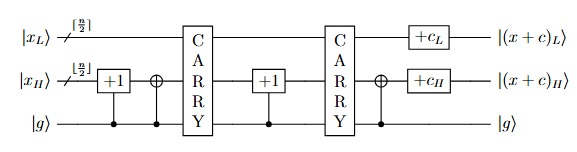

In [89]:
def quantum_adder(qc: QuantumCircuit, x_bits: list[int], c: int, g_bits: list[int]):
  """Implements adding the classical integer 'c' to the quantum register x, whose bits are given by 'x-bits'. Note that len(x_bits) must also be the number
  of bits in 'c'."""

  g_bit_main, g_bit_sub = g_bits[:2]
  if c == 0: return
  n = floor(log2(c)) + 1

  if len(x_bits) < n:
      raise ValueError(f"Quantum Circuit does not have enough x-bits! ({len(x_bits)} < {n})")
  while len(x_bits) > n:
      n += 1

  c_low = c % (2 ** ((n + 1) // 2))
  c_high = c // (2 ** ((n + 1) // 2))

  x_low_bits = x_bits[:(n + 1) // 2]
  x_high_bits = x_bits[(n + 1) // 2:]

  if n % 2:
      incrementer(qc, [g_bit_main] + x_high_bits, x_low_bits)
      qc.x(g_bit_main)

      for bit in x_high_bits:
          qc.cx(g_bit_main, bit)

      qc.barrier()

      toffoli_carry(qc, x_low_bits, x_high_bits, g_bit_main, c_low)

      incrementer(qc, [g_bit_main] + x_high_bits, x_low_bits)
      qc.x(g_bit_main)

      toffoli_carry(qc, x_low_bits, x_high_bits, g_bit_main, c_low)

      qc.barrier()

      for bit in x_high_bits:
          qc.cx(g_bit_main, bit)

      qc.barrier()
  else:
      incrementer(qc, [g_bit_main] + x_high_bits, x_low_bits + [g_bit_sub])
      qc.x(g_bit_main)

      for bit in x_high_bits:
          qc.cx(g_bit_main, bit)

      qc.barrier()

      toffoli_carry(qc, x_low_bits, x_high_bits[:-1], g_bit_main, c_low)

      incrementer(qc, [g_bit_main] + x_high_bits, x_low_bits + [g_bit_sub])
      qc.x(g_bit_main)

      toffoli_carry(qc, x_low_bits, x_high_bits[:-1], g_bit_main, c_low)

      qc.barrier()

      for bit in x_high_bits:
          qc.cx(g_bit_main, bit)

      qc.barrier()

  if n == 1 and c == 1:
    qc.x(x_bits[0])
    return

  quantum_adder(qc, x_low_bits, c_low, g_bits)
  quantum_adder(qc, x_high_bits, c_high, g_bits)

def controlled_quantum_adder(qc: QuantumCircuit, x_bits: list[int], c: int, g_bits: list[int], control_bit: int) -> None:
  """Implements a controlled version of adding the classical integer 'c' to the quantum register x, whose bits are given by 'x-bits'. Note that len(x_bits) must also be the number
  of bits in 'c'."""

  g_bit_main, g_bit_sub = g_bits[:2]
  if c == 0: return
  n = floor(log2(c)) + 1

  if len(x_bits) < n:
      raise ValueError(f"Quantum Circuit does not have enough x-bits! ({len(x_bits)} < {n})")
  while len(x_bits) > n:
      n += 1

  c_low = c % (2 ** ((n + 1) // 2))
  c_high = c // (2 ** ((n + 1) // 2))

  x_low_bits = x_bits[:(n + 1) // 2]
  x_high_bits = x_bits[(n + 1) // 2:]

  if n % 2:
      incrementer(qc, [g_bit_main] + x_high_bits, x_low_bits)
      qc.x(g_bit_main)

      for bit in x_high_bits:
          qc.cx(g_bit_main, bit)

      qc.barrier()

      controlled_toffoli_carry(qc, x_low_bits, x_high_bits, g_bit_main, c_low, control_bit)

      incrementer(qc, [g_bit_main] + x_high_bits, x_low_bits)
      qc.x(g_bit_main)

      controlled_toffoli_carry(qc, x_low_bits, x_high_bits, g_bit_main, c_low, control_bit)

      qc.barrier()

      for bit in x_high_bits:
          qc.cx(g_bit_main, bit)

      qc.barrier()
  else:
      incrementer(qc, [g_bit_main] + x_high_bits, x_low_bits + [g_bit_sub])
      qc.x(g_bit_main)

      for bit in x_high_bits:
          qc.cx(g_bit_main, bit)

      qc.barrier()

      controlled_toffoli_carry(qc, x_low_bits, x_high_bits[:-1], g_bit_main, c_low, control_bit)

      incrementer(qc, [g_bit_main] + x_high_bits, x_low_bits + [g_bit_sub])
      qc.x(g_bit_main)

      controlled_toffoli_carry(qc, x_low_bits, x_high_bits[:-1], g_bit_main, c_low, control_bit)

      qc.barrier()

      for bit in x_high_bits:
          qc.cx(g_bit_main, bit)

      qc.barrier()

  if n == 1 and c == 1:
    qc.cx(control_bit, x_bits[0])
    return

  controlled_quantum_adder(qc, x_low_bits, c_low, g_bits, control_bit)
  controlled_quantum_adder(qc, x_high_bits, c_high, g_bits, control_bit)

## The Comparator (CMP)

CMP is a variation of the **carry** circuit that implements the transformation $|x\rangle|g\rangle|0\rangle \rightarrow |x\rangle|g\rangle|\text{int}(x < c)\rangle$. In other words, it outputs a $1$ if $x < c$. This would be useful in the quantum modular adder, the building block of the modular multiplier and the modular exponentiation circuit.

The **controlled** and **double controlled** versions are also available, and would be useful in later constructions.

In [85]:
def cmp(qc: QuantumCircuit, b_bits: list[int], g_bits: list[int], zero_bit: int, c: int) -> None:
    for bit in b_bits:
      qc.x(bit)

    toffoli_carry(qc, b_bits, g_bits, zero_bit, c)

    for bit in b_bits:
      qc.x(bit)

def ccmp(qc: QuantumCircuit, b_bits: list[int], g_bits: list[int], zero_bit: int, c: int, control_bit: int) -> None:
    for bit in b_bits:
      qc.x(bit)

    controlled_toffoli_carry(qc, b_bits, g_bits, zero_bit, c, control_bit)

    for bit in b_bits:
      qc.x(bit)

def cccmp(qc: QuantumCircuit, b_bits: list[int], g_bits: list[int], zero_bit: int, c: int, cb_1: int, cb_2: int) -> None:
    for bit in b_bits:
      qc.x(bit)

    cc_toffoli_carry(qc, b_bits, g_bits, zero_bit, c, cb_1, cb_2)

    for bit in b_bits:
      qc.x(bit)

## The Quantum Modular Adder

This combines the **CMP** and the (controlled) **quantum addition circuit** to carry out the transformation $|x\rangle|0\rangle|g\rangle \rightarrow |(x + a) \text{ }(mod\text{ } N) \rangle|0\rangle |g\rangle,$ where $|g\rangle$ has at least $(n - 1)$ dirty ancilla qubits.

The **controlled** and **double controlled** versions are also available, as well as the reverse operation **modular subtraction**, which would be useful in the uncompute routine in the quantum modular exponentiation circuit.

Below is a high-level overview of the circuit:



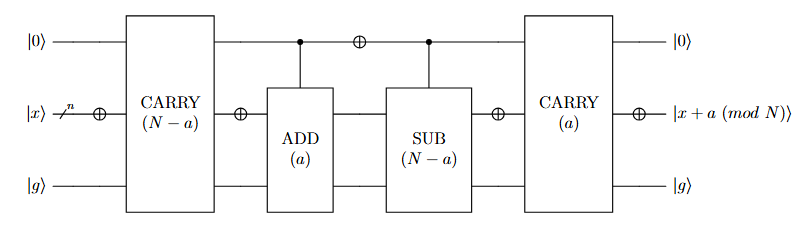

In [ ]:
def quantum_modular_adder(qc: QuantumCircuit, a: int, N: int, x_bits: list[int], zero_bit: int, g_bits: list[int]) -> None:
  if a == N: return
  n = len(x_bits)

  if len(bin(a)[2:]) > n:
    raise ValueError()

  cmp(qc, x_bits, g_bits, zero_bit, N - a)

  sub_complement =  2 ** n - (N - a)

  controlled_quantum_adder(qc, x_bits, a, g_bits, zero_bit)

  qc.x(zero_bit)

  controlled_quantum_adder(qc, x_bits, sub_complement, g_bits, zero_bit)

  cmp(qc, x_bits, g_bits, zero_bit, a)

def controlled_quantum_mod_add(qc: QuantumCircuit, a: int, N: int, x_bits: list[int], zero_bit: int, g_bits: list[int], control_bit: int) -> None:
  if a == N or a == 0: return
  n = len(x_bits)

  if len(bin(a)[2:]) > n:
    raise ValueError()

  ccmp(qc, x_bits, g_bits, zero_bit, N - a, control_bit)

  sub_complement =  2 ** n - (N - a)

  controlled_quantum_adder(qc, x_bits, a, g_bits, zero_bit)

  qc.cx(control_bit, zero_bit)

  controlled_quantum_adder(qc, x_bits, sub_complement, g_bits, zero_bit)

  ccmp(qc, x_bits, g_bits, zero_bit, a, control_bit)

def cc_quantum_mod_add(qc: QuantumCircuit, a: int, N: int, x_bits: list[int], zero_bit: int, g_bits: list[int], cb_1: int, cb_2: int) -> None:
  if a in {0, N}: return
  n = len(x_bits)

  if len(bin(a)[2:]) > n:
    raise ValueError()

  cccmp(qc, x_bits, g_bits, zero_bit, N - a, cb_1, cb_2)

  sub_complement =  2 ** n - (N - a)

  controlled_quantum_adder(qc, x_bits, a, g_bits, zero_bit)

  qc.ccx(cb_2, cb_1, zero_bit)

  controlled_quantum_adder(qc, x_bits, sub_complement, g_bits, zero_bit)

  cccmp(qc, x_bits, g_bits, zero_bit, a, cb_1, cb_2)

def cc_quantum_mod_sub(qc: QuantumCircuit, a: int, N: int, x_bits: list[int], zero_bit: int, g_bits: list[int], cb_1: int, cb_2: int) -> None:
  if a in {0, N}: return
  n = len(x_bits)

  if len(bin(a)[2:]) > n:
    raise ValueError()

  cccmp(qc, x_bits, g_bits, zero_bit, a, cb_1, cb_2)

  sub_complement =  2 ** n - a

  qc.ccx(cb_2, cb_1, zero_bit)

  controlled_quantum_adder(qc, x_bits, sub_complement, g_bits, zero_bit)

  qc.ccx(cb_2, cb_1, zero_bit)

  controlled_quantum_adder(qc, x_bits, N - a, g_bits, zero_bit)

  cccmp(qc, x_bits, g_bits, zero_bit, N - a, cb_1, cb_2)

## The Quantum Modular Multiplier

This circuit uses "repeated add-and-shift" to arrive at the transformation $|x\rangle|0\rangle = |x\rangle|ax \text{ }(mod \text{ }N)\rangle$. The technique used is based on the identity $$ax \text{ } (mod \text{ } N) = \sum_{i=0}^{n-1}\left(a2^{i}\cdot x_{i}\right)\text{} (mod\text{ } N),$$

where addition is done mod $N$. This means that modular multiplication can be viewed as several controlled modular additions.

Variations of this circuit include the **controlled** version and a reversed variant, called ```controlled_quantum_neg_mod_mul```. This is needed in the uncompute routine in the modular exponentiation circuit.

In [ ]:
def quantum_mod_mul(qc: QuantumCircuit, a: int, N: int, x_bits: list[int], output_bits: list[int], zero_bit: int) -> None:
  for i in range(len(x_bits)):
      shift = (a * mod_exp(2, i, N)) % N
      g_bits = [j for j in x_bits if j != x_bits[i]]
      controlled_quantum_mod_add(qc, shift, N, output_bits, zero_bit, g_bits, x_bits[i])

def controlled_quantum_mod_mul(qc: QuantumCircuit, a: int, N: int, x_bits: list[int], output_bits: list[int], zero_bit: int, control_bit: int) -> None:
  for i in range(len(x_bits)):
      shift = (a * mod_exp(2, i, N)) % N
      g_bits = [j for j in x_bits if j != x_bits[i]]
      cc_quantum_mod_add(qc, shift, N, output_bits, zero_bit, g_bits, x_bits[i], control_bit)

def controlled_quantum_neg_mod_mul(qc: QuantumCircuit, a: int, N: int, x_bits: list[int], output_bits: list[int], zero_bit: int, control_bit: int) -> None:
  for i in range(len(x_bits)):
      shift = (a * mod_exp(2, i, N)) % N
      g_bits = [j for j in x_bits if j != x_bits[i]]
      cc_quantum_mod_sub(qc, shift, N, output_bits, zero_bit, g_bits, x_bits[i], control_bit)

## The Quantum Modular Exponentiation Circuit

This circuit uses several controlled modular multiplications to arrive at the construction $|x \rangle |b \rangle \rightarrow |x \rangle |b \cdot a^x \text{ } (mod \text{ } N) \rangle.$

The circuit uses the **uncompute** routine to keep the qubit count constant, and is outlined as follows:


*   Swap the two registers.
*   Run the modular multiplication in reverse (using ```controlled_quantum_neg_mod_mul```), with the constant of multiplication being $a^{-1}\text{ }(mod\text{ } N)$, the inverse of $a$ mod $N$.



In [90]:
def quantum_mod_exp(qc: QuantumCircuit, a: int, N: int, x_bits: list[int], output_bits: list[int], zero_bits: list[int], lone_zb: int) -> None:
  if len(output_bits) != len(zero_bits):
      raise ValueError(f"Output bits aren't as many as zero bits! {output_bits} != {zero_bits}")
  for i in range(len(x_bits)):
    a_i = mod_exp(a, 2 ** i, N)
    controlled_quantum_mod_mul(qc, a_i, N, output_bits, zero_bits, lone_zb, x_bits[i]) # repeated controlled multiplication

    # Uncompute
    for j in range(len(output_bits)):
      qc.cswap(x_bits[i], output_bits[j], zero_bits[j])

    controlled_quantum_neg_mod_mul(qc, inverse_mod_N(a_i, N), N, output_bits, zero_bits, lone_zb, x_bits[i])

## Finale: QPE circuit for Shor's Algorithm

This function puts everything together by constructing a circuit that implements Shor's algorithm.

In [ ]:
def shor_algorithm_circuit(N: int, a: int):
    """Constructs the toffoli-based circuit implementing Shor's algorithm for given N and a. It is assumed that gcd(a, N) = 1."""
    n = floor(log2(N)) + 1

    qc = QuantumCircuit(4 * n + 1, 2 * n)
    for i in range(n):
      qc.h(i)

    qc.x(n)

    quantum_mod_exp(qc, a, N, l(2 * n), lr(2 * n, 3 * n), lr(3 * n, 4 * n), 4 * n)

    iqft(qc, l(2 * n))

    for i in range(2 * n):
      qc.measure(i, i)

    return qc

In [ ]:
def factorize(N: int) -> int | None:
  """Returns a (possible) factor of N - using a quantum circuit!"""
  denom = 1
  while denom % 2:
    a = random.randint(2, N - 1)
    b = gcd(a, N)
    if b != 1:
       print("Found a trivial factor!")
       return b
    print(f"Didn't immediately find a factor of {N}. Initiating quantum subroutine with a = {a}.")
    qc = shor_algorithm_circuit(N, a)

    counts = SamplerV2().run([qc], shots=1000).result()[0].data.c.get_counts()
    bit_string = random.sample(list(counts.keys()), k=1, counts=list(counts.values()))[0]

    decimal = 0

    for i in range(len(bit_string)):
      digit = int(bit_string[i])
      decimal = (decimal + digit) / 2

    f = Fraction(decimal).limit_denominator(N)
    denom = f.denominator
    if denom % 2:
      print(f"Quantum subroutine resulted in an odd denominator ({denom})! Retrying.")
  if not ((a ** (denom // 2) + 1 % N) == 0):
    p, q = gcd(a ** (denom // 2) - 1, N), gcd(a ** (denom // 2) + 1, N)

    if N % p == 0:
      return p

    if N % q == 0:
      return q

  print(f"Failed to find a factor of {N} for a = {a}. Retrying.")
  return factorize(N) #Try again!

In [ ]:
# Just for fun

factorize(15)

##  REFERENCES

1.   Thomas Häner, Martin Roetteler, and Krysta M. Svore. “Factoring using 2n+2 qubits with Toffoli based modular multiplication.” Quantum Information & Computation, vol. 17, no. 7–8, pp. 673–684, Jun. 01, 2017. [arXiv:1611.07995](https://https://arxiv.org/abs/1611.07995)
2.   Craig Gidney. “Creating bigger controlled nots from single qubit, Toffoli, and CNOT gates, without workspace.” StackExchange Q&A, 2015. [https://cs.stackexchange.com/questions/40933/](https://cs.stackexchange.com/questions/40933/)


